In [2]:
from typing import Any, Callable, Dict, Optional, Tuple, List
import xml.etree.ElementTree as Et
from xml.etree.ElementTree import Element, ElementTree

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torchvision
from torchvision import utils
from torchvision import models
from torchvision import transforms
from torchvision.transforms.functional import to_tensor, to_pil_image

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import cv2
import collections
import numpy as np

import os
import copy
import time

In [3]:
dataset_path = os.path.expanduser("~/Desktop/joo/data/nest/preprocessing/")
classes = ["grass","tree","nest"]

In [4]:
class MyDataset(Dataset):
    def __init__(self, dataset_path, dataset_type, transform=None):
        self.path = dataset_path
        if dataset_type == "train": self.dataset_type = "train/"
        elif dataset_type == "test": self.dataset_type = "test/"
        elif dataset_type == "val": self.dataset_type = "val/"
        else: print("[Error Message] : Please check datatype") 
        
        try:
            self.ann_root, self.ann_dir, self.ann_files = next(os.walk(os.path.join(self.path, self.dataset_type, "Annotations")))
            self.img_root, self.amg_dir, self.img_files = next(os.walk(os.path.join(self.path, self.dataset_type, "JPEGImages")))
            self.images = [os.path.join(self.img_root, x)for x in self.img_files]
            self.targets = [os.path.join(self.ann_root, x)for x in self.ann_files]
            self.images.sort()
            self.targets.sort()

        except AttributeError as e: print(e)
        except StopIteration as e: print("[Error Message] : please check data path")
        
        self.transform = transform
            
    def __len__(self):
        return len(self.ann_files)

    def __getitem__(self, index):
        # Function to get the data from XML Annotation
        image = cv2.imread(self.images[index], cv2.IMREAD_COLOR)
        b, g, r = cv2.split(image)   # img파일을 b,g,r로 분리
        image = cv2.merge([r, g, b])  # b, r을 바꿔서 Merge
        target = self.parse_voc_xml(Et.parse(self.targets[index]).getroot())  # xml파일 분석하여 dict으로 받아오기

        targets = []    # 바운딩 박스 좌표
        labels = []     # 바운딩 박스 클래스
        
        # 바운딩 박스 정보 받아오기
        for t in target['annotation']['object']:
            label = np.zeros(5)
            label[:] = t['bndbox']['xmin'], t['bndbox']['ymin'], t['bndbox']['xmax'], t['bndbox']['ymax'], classes.index(t['name'])
            targets.append(list(map(int, label[:4])))
            labels.append(label[4])

        return image, targets, tuple(labels)
    
    # xml 파일을 dictionary로 반환
    def parse_voc_xml(self, node: Et.Element) -> Dict[str, Any]:
        voc_dict: Dict[str, Any] = {}
        children = list(node)
        if children:
            def_dic: Dict[str, Any] = collections.defaultdict(list)
            for dc in map(self.parse_voc_xml, children):
                for ind, v in dc.items():
                    def_dic[ind].append(v)
            if node.tag == "annotation":
                def_dic["object"] = [def_dic["object"]]
            voc_dict = {node.tag: {ind: v[0] if len(v) == 1 else v for ind, v in def_dic.items()}}
        if node.text:
            text = node.text.strip()
            if not children:
                voc_dict[node.tag] = text
        return voc_dict


In [5]:
train_ds = MyDataset(dataset_path, "train")
val_ds = MyDataset(dataset_path, "val")
test_ds = MyDataset(dataset_path, "test")
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))
print(test_ds[0][0].shape)

5974
312
417
(800, 800, 3)


(2.0,)


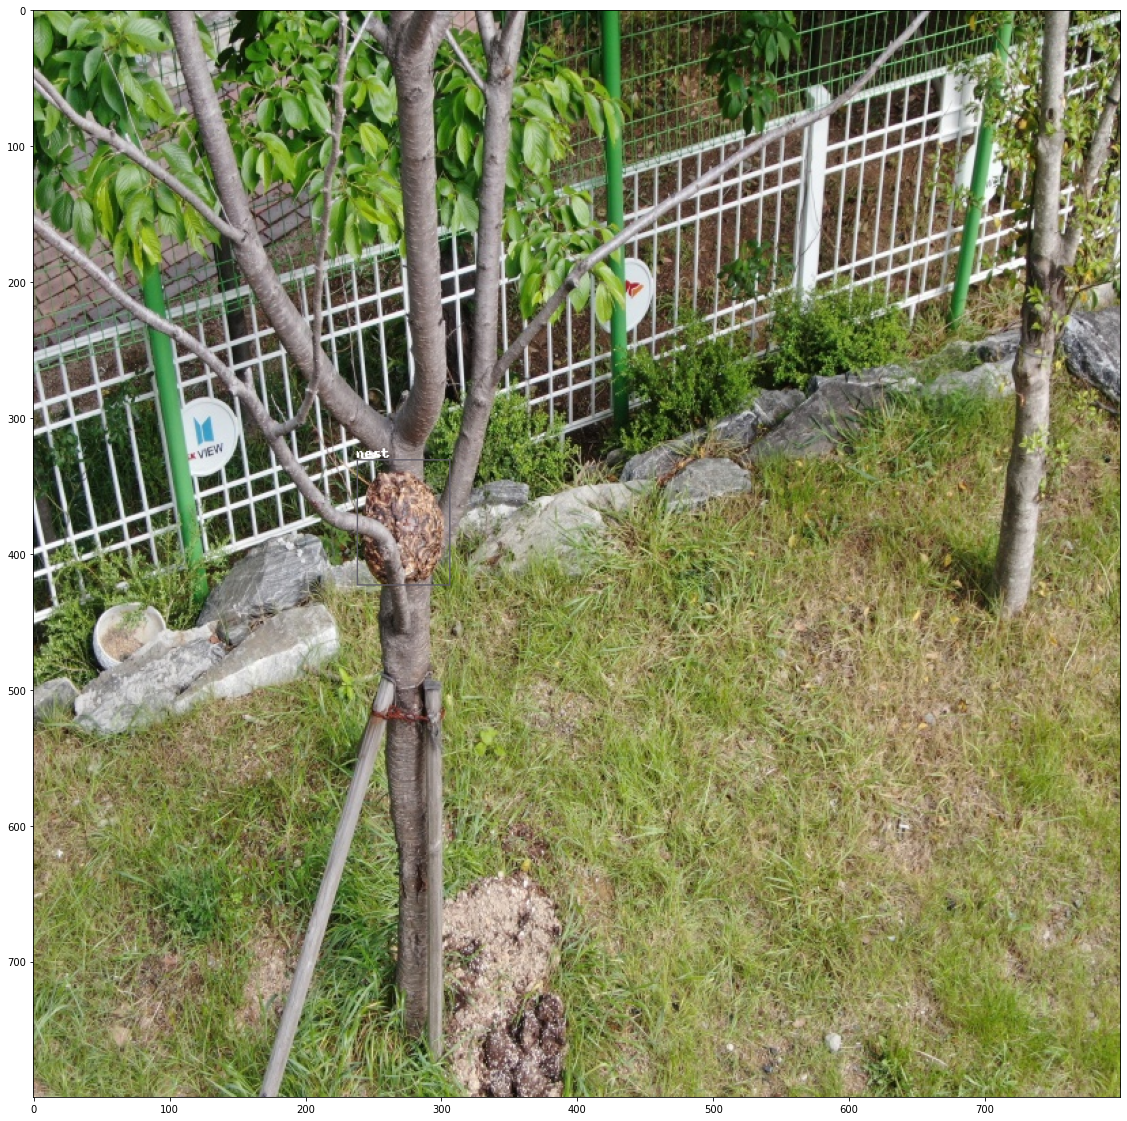

In [6]:
# 샘플 이미지 확인
img, target, label = train_ds[7]
colors = np.random.randint(0, 255, size=(80, 3), dtype='uint8')  # 바운딩 박스 색상

# 시각화 함수
def show(img, targets, labels, classes=classes):
    img = to_pil_image(img)
    draw = ImageDraw.Draw(img)
    targets = np.array(targets)
    print(labels)
    W, H = img.size

    for tg, label in zip(targets, labels):
        id_ = int(label)  # class
        bbox = tg[:4]    # [x1, y1, x2, y2]

        color = [int(c) for c in colors[id_]]
        name = classes[id_]

        draw.rectangle(((bbox[0], bbox[1]), (bbox[2], bbox[3])),outline=tuple(color), width=1)
        draw.text((bbox[0], bbox[1]-10), name, fill=(255, 255, 255, 0))
        
    plt.imshow(np.array(img))

plt.figure(figsize=(20, 20))
show(img, target, label)

In [7]:
train_dl = DataLoader(train_ds, batch_size=2,shuffle=True)
val_dl = DataLoader(val_ds, batch_size=2, shuffle=True)

In [8]:
print(len(train_dl))
print(len(val_dl))

2987
156


In [9]:
for tensor_img,xy,label in train_dl:
    print(f"tensor_img_shape : {tensor_img.shape}\n")
    print(f"xy : {xy}\n")
    print(f"label : {label}\n")
    break

tensor_img_shape : torch.Size([2, 800, 800, 3])

xy : [[tensor([343, 367]), tensor([279, 234]), tensor([408, 403]), tensor([366, 289])]]

label : [tensor([2., 2.], dtype=torch.float64)]



In [10]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 2080 Ti


In [11]:
# only print feature extraction part of VGG16

backbone = torchvision.models.vgg16(pretrained=True).to(device)
features = list(backbone.features)
print(len(features))
print(features)


31
[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1

In [12]:
# only collect layers with output feature map size (W, H) < 50

dummy_img = torch.zeros((1, 3, 800, 800)).float()  # test image array
print(dummy_img.shape)

req_features = []
output = dummy_img.clone().to(device)

for feature in features:
    output = feature(output)
    # print(output.size()) # => torch.Size([batch_size, channel, width, height])
    if output.size()[2] < 800//16:  # 800/16=50
        break
    req_features.append(feature)
    out_channels = output.size()[1]

print(len(req_features))
# print(req_features)
print(out_channels)

torch.Size([1, 3, 800, 800])
30
512


In [13]:
feature_map_size = (50, 50)
# The first center coors is (8, 8)
ctr_y = np.arange(8, 800, 16)
ctr_x = np.arange(8, 800, 16)

ctr = np.zeros((*feature_map_size, 2))
for idx, y in enumerate(ctr_y):
    ctr[idx, :, 0] = y
    ctr[idx, :, 1] = ctr_x
print(ctr.shape)

(50, 50, 2)


In [14]:
# convert this list into a Seqeuntial module

faster_rcnn_feature_extractor = nn.Sequential(*req_features)

In [15]:
# test the results of the input image pass through the feature extractor

transform = transforms.Compose([transforms.ToTensor()])
imgTensor = transform(img).to(device)
imgTensor = imgTensor.unsqueeze(0)
output_map = faster_rcnn_feature_extractor(imgTensor)

print(output_map.size())

torch.Size([1, 512, 50, 50])


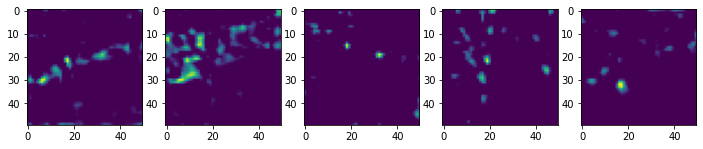

In [16]:
# visualize the first 5 channels of the 50*50*512 feature maps

imgArray = output_map.data.cpu().numpy().squeeze(0)
fig = plt.figure(figsize=(12, 4))
figNo = 1

for i in range(5):
    fig.add_subplot(1, 5, figNo)
    plt.imshow(imgArray[i])
    figNo += 1
    
plt.show()

In [17]:
# sub-sampling rate = 1/16
# image size : 800x800
# sub-sampled feature map size : 800 x 1/16 = 50
# 50 x 50 = 2500 anchors and each anchor generate 9 anchor boxes
# total anchor boxes = 50 x 50 x 9 = 22500
# x,y intervals to generate anchor box center

feature_size = 800 // 16
ctr_x = np.arange(16, (feature_size+1) * 16, 16)
ctr_y = np.arange(16, (feature_size+1) * 16, 16)
print(len(ctr_x))
print(ctr_x)
print(len(ctr_y))
print(ctr_y)

50
[ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]
50
[ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]


In [18]:
# coordinates of the 255 center points to generate anchor boxes

index = 0
ctr = np.zeros((2500, 2))

for i in range(len(ctr_x)):
    for j in range(len(ctr_y)):
        ctr[index, 1] = ctr_x[i] - 8
        ctr[index, 0] = ctr_y[j] - 8
        index += 1

# ctr => [[center x, center y], ...]
print(ctr.shape)
print(ctr[:10, :])

(2500, 2)
[[  8.   8.]
 [ 24.   8.]
 [ 40.   8.]
 [ 56.   8.]
 [ 72.   8.]
 [ 88.   8.]
 [104.   8.]
 [120.   8.]
 [136.   8.]
 [152.   8.]]


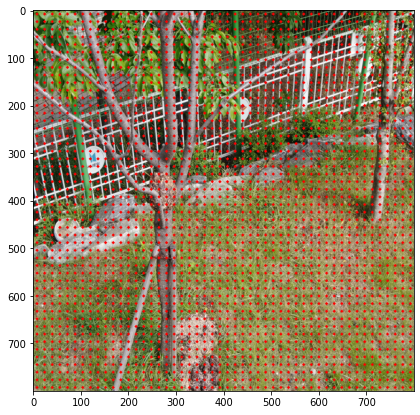

In [19]:
# display the 2500 anchors within image
img_clone2 = np.copy(img)
ctr_int = ctr.astype("int32")

plt.figure(figsize=(7, 7))
for i in range(ctr.shape[0]):
    cv2.circle(img_clone2, (ctr_int[i][0], ctr_int[i][1]),
              radius=1, color=(255, 0, 0), thickness=3)
plt.imshow(img_clone2)
plt.show()

In [59]:
# for each of the 2500 anchors, generate 9 anchor boxes
# 2500 x 9 = 22500 anchor boxes

ratios = [0.5, 1, 2]
scales = [8, 16, 32]
sub_sample = 16

anchor_boxes = np.zeros(((feature_size * feature_size * 9), 4))
index = 0

for c in ctr:                        # per anchors
    ctr_y, ctr_x = c
    for i in range(len(ratios)):     # per ratios
        for j in range(len(scales)): # per scales
            
            # anchor box height, width
            h = sub_sample * scales[j] * np.sqrt(ratios[i])
            w = sub_sample * scales[j] * np.sqrt(1./ ratios[i])
            
            # anchor box [x1, y1, x2, y2]
            anchor_boxes[index, 1] = ctr_y - h / 2.
            anchor_boxes[index, 0] = ctr_x - w / 2.
            anchor_boxes[index, 3] = ctr_y + h / 2.
            anchor_boxes[index, 2] = ctr_x + w / 2.
            index += 1
            
print(anchor_boxes.shape)
print(anchor_boxes[:, :])

(22500, 4)
[[ -82.50966799  -37.254834     98.50966799   53.254834  ]
 [-173.01933598  -82.50966799  189.01933598   98.50966799]
 [-354.03867197 -173.01933598  370.03867197  189.01933598]
 ...
 [ 746.745166    701.49033201  837.254834    882.50966799]
 [ 701.49033201  610.98066402  882.50966799  973.01933598]
 [ 610.98066402  429.96132803  973.01933598 1154.03867197]]


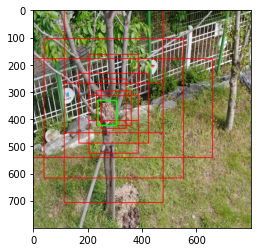

In [72]:
# display the anchor boxes of one anchor and the ground truth boxes

img_clone = np.copy(img)

# draw random anchor boxes
for i in range(8295, 8304):
    x1 = int(anchor_boxes[i][0])
    y1 = int(anchor_boxes[i][1])
    x2 = int(anchor_boxes[i][2])
    y2 = int(anchor_boxes[i][3])
    
    cv2.rectangle(img_clone, (x1, y1), (x2, y2), color=(255, 0, 0),
                 thickness=2)

# draw ground truth boxes
for i in range(len(target)):
    cv2.rectangle(img_clone, (target[i][0], target[i][1]), 
                             (target[i][2], target[i][3]),
                 color=(0, 255, 0), thickness=3)

plt.imshow(img_clone)
plt.show()

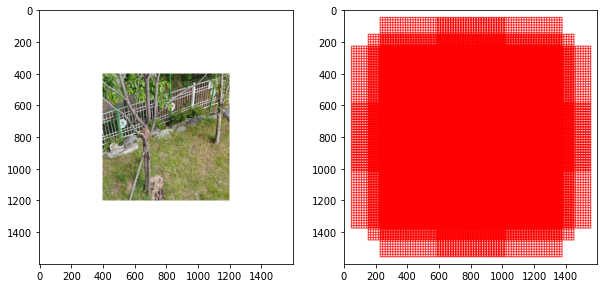

In [23]:
# draw all anchor boxes

# add paddings(can't draw anchor boxes out of image boundary)
img_clone3 = np.copy(img)
img_clone4 = cv2.copyMakeBorder(img_clone3,400,400,400,400,cv2.BORDER_CONSTANT, value=(255, 255, 255))
img_clone5 = np.copy(img_clone4)

for i in range(len(anchor_boxes)):
    x1 = int(anchor_boxes[i][0])
    y1 = int(anchor_boxes[i][1])
    x2 = int(anchor_boxes[i][2])
    y2 = int(anchor_boxes[i][3])
    
    cv2.rectangle(img_clone5, (x1+400, y1+400), (x2+400, y2+400), color=(255, 0, 0),
                 thickness=3)

plt.figure(figsize=(10, 10))
plt.subplot(121), plt.imshow(img_clone4)
plt.subplot(122), plt.imshow(img_clone5)
plt.show()

In [24]:
# ignore the cross-boundary anchor boxes
# valid anchor boxes with (x1, y1) > 0 and (x2, y2) <= 800

index_inside = np.where(
        (anchor_boxes[:, 0] >= 0) &
        (anchor_boxes[:, 1] >= 0) &
        (anchor_boxes[:, 2] <= 800) &
        (anchor_boxes[:, 3] <= 800))[0]

print(index_inside.shape)

# only 8940 anchor boxes are inside the boundary out of 22500
valid_anchor_boxes = anchor_boxes[index_inside]
print(valid_anchor_boxes.shape)

(8940,)
(8940, 4)


In [30]:
# calculate Iou of the valid anchor boxes
# since we have 8940 anchor boxes and 4 ground truth objects,
# we should get an array with (8940, 4) as the output
# [IoU with gt box1, IoU with gt box2, IoU with gt box3,IoU with gt box4]

ious = np.empty((len(valid_anchor_boxes),4), dtype=np.float32)
ious.fill(0)

# anchor boxes
for i, anchor_box in enumerate(valid_anchor_boxes):
    xa1, ya1, xa2, ya2 = anchor_box
    anchor_area = (xa2 - xa1) * (ya2 - ya1)
    
    # ground truth boxes
    for j, gt_box in enumerate(target):
        xb1, yb1, xb2, yb2 = gt_box
        box_area = (xb2 - xb1) * (yb2 - yb1)
        
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            inter_area = (inter_x2 - inter_x1) * (inter_y2 - inter_y1)
            iou = inter_area / (anchor_area + box_area - inter_area)
        else:
            iou = 0
        
        ious[i, j] = iou
        
print(ious.shape)
print(ious[8930:8940, :])

(8940, 4)
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [31]:
# what anchor box has max ou with the ground truth box

gt_argmax_ious = ious.argmax(axis=0)
print(gt_argmax_ious)

gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
print(gt_max_ious)

gt_argmax_ious = np.where(ious == gt_max_ious)[0]
print(gt_argmax_ious)

[2068    0    0    0]
[0.38183594 0.         0.         0.        ]
[   0    0    0 ... 8939 8939 8939]


In [27]:
# what ground truth bbox is associated with each anchor box

argmax_ious = ious.argmax(axis=1)
print(argmax_ious.shape)
print(argmax_ious)

max_ious = ious[np.arange(len(index_inside)), argmax_ious]
print(max_ious)

(8940,)
[0 0 0 ... 0 0 0]
[0. 0. 0. ... 0. 0. 0.]


In [28]:
# set the labels of 8940 valid anchor boxes to -1(ignore)

label = np.empty((len(index_inside),), dtype=np.int32)
label.fill(-1)
print(label.shape)

(8940,)


In [29]:
# use IoU to assign 1 (objects) to two kind of anchors
# a) the anchors with the highest IoU overlap with a ground truth box
# b) an anchor that has an IoU overlap higher than 0.7 with ground truth box

# Assign 0 (background) to an anchor if its IoU ratio is lower than 0.3

pos_iou_threshold = 0.7
neg_iou_threshold = 0.3

label[gt_argmax_ious] = 1
label[max_ious >= pos_iou_threshold] = 1
label[max_ious < neg_iou_threshold] = 0

In [32]:
# Every time mini-batch training take only 256 valid anchor boxes to train RPN
# of which 128 positive examples, 128 negative-examples
# disable leftover positive/negative anchors 
n_sample = 256
pos_ratio = 0.5
n_pos = pos_ratio * n_sample

pos_index = np.where(label == 1)[0]

if len(pos_index) > n_pos:
    disable_index = np.random.choice(pos_index,
                                    size = (len(pos_index) - n_pos),
                                    replace=False)
    label[disable_index] = -1
    
n_neg = n_sample * np.sum(label == 1)
neg_index = np.where(label == 0)[0]

if len(neg_index) > n_neg:
    disable_index = np.random.choice(neg_index, 
                                    size = (len(neg_index) - n_neg), 
                                    replace = False)
    label[disable_index] = -1

In [33]:
# convert the format of valid anchor boxes [x1, y1, x2, y2]
target = np.array(target)

# For each valid anchor box, find the groundtruth object which has max_iou 
max_iou_bbox = target[argmax_ious]
print(max_iou_bbox.shape)

height = valid_anchor_boxes[:, 3] - valid_anchor_boxes[:, 1]
width = valid_anchor_boxes[:, 2] = valid_anchor_boxes[:, 0]
ctr_y = valid_anchor_boxes[:, 1] + 0.5 * height
ctr_x = valid_anchor_boxes[:, 0] + 0.5 * width

base_height = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
base_width = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
base_ctr_y = max_iou_bbox[:, 1] + 0.5 * base_height
base_ctr_x = max_iou_bbox[:, 0] + 0.5 * base_width

eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)

dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)

anchor_locs = np.vstack((dx, dy, dw, dh)).transpose()
print(anchor_locs.shape)

(8940, 4)
(8940, 4)


In [34]:
# First set the label=-1 and locations=0 of the 22500 anchor boxes, 
# and then fill in the locations and labels of the 8940 valid anchor boxes
# NOTICE: For each training epoch, we randomly select 128 positive + 128 negative 
# from 8940 valid anchor boxes, and the others are marked with -1

anchor_labels = np.empty((len(anchor_boxes),), dtype=label.dtype)
anchor_labels.fill(-1)
anchor_labels[index_inside] = label
print(anchor_labels.shape)
print(anchor_labels[:10])

anchor_locations = np.empty((len(anchor_boxes),) + anchor_boxes.shape[1:], dtype=anchor_locs.dtype)
anchor_locations.fill(0)
anchor_locations[index_inside, :] = anchor_locs
print(anchor_locations.shape)
print(anchor_locations[:10, :])

(22500,)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
(22500, 4)
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [35]:
# Send the features of the input image to the Region Proposal Network (RPN), 
# predict 22500 region proposals (ROIs)

in_channels = 512
mid_channels = 512
n_anchor = 9

conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1).to(device)
conv1.weight.data.normal_(0, 0.01)
conv1.bias.data.zero_()

# bounding box regressor
reg_layer = nn.Conv2d(mid_channels, n_anchor * 4, 1, 1, 0).to(device)
reg_layer.weight.data.normal_(0, 0.01)
reg_layer.bias.data.zero_()

# classifier(object or not)
cls_layer = nn.Conv2d(mid_channels, n_anchor * 2, 1, 1, 0).to(device)
cls_layer.weight.data.normal_(0, 0.01)
cls_layer.bias.data.zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')

In [36]:
x = conv1(output_map.to(device)) # output_map = faster_rcnn_feature_extractor(imgTensor)
pred_anchor_locs = reg_layer(x) # bounding box regresor output
pred_cls_scores = cls_layer(x)  # classifier output 

print(pred_anchor_locs.shape, pred_cls_scores.shape)

torch.Size([1, 36, 50, 50]) torch.Size([1, 18, 50, 50])


In [37]:
# Convert RPN to predict the position and classification format of the anchor box
# Position: [1, 36(9*4), 50, 50] => [1, 22500(50*50*9), 4] (dy, dx, dh, dw) 
# Classification: [1, 18(9*2), 50, 50] => [1, 22500, 2] (1, 0)

pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
print(pred_anchor_locs.shape)

pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()
print(pred_cls_scores.shape)

objectness_score = pred_cls_scores.view(1, 50, 50, 9, 2)[:, :, :, :, 1].contiguous().view(1, -1)
print(objectness_score.shape)

pred_cls_scores = pred_cls_scores.view(1, -1, 2)
print(pred_cls_scores.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 50, 50, 18])
torch.Size([1, 22500])
torch.Size([1, 22500, 2])


In [38]:
# According to the 22500 ROIs predicted by RPN and 22500 anchor boxes, 
# calculate the RPN loss¶
print(pred_anchor_locs.shape)
print(pred_cls_scores.shape)
print(anchor_locations.shape)
print(anchor_labels.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 22500, 2])
(22500, 4)
(22500,)


In [39]:
rpn_loc = pred_anchor_locs[0]
rpn_score = pred_cls_scores[0]

gt_rpn_loc = torch.from_numpy(anchor_locations)
gt_rpn_score = torch.from_numpy(anchor_labels)

print(rpn_loc.shape, rpn_score.shape,
      gt_rpn_loc.shape, gt_rpn_score.shape)

torch.Size([22500, 4]) torch.Size([22500, 2]) torch.Size([22500, 4]) torch.Size([22500])


In [40]:
# For classification we use cross-entropy loss
rpn_cls_loss = F.cross_entropy(rpn_score, gt_rpn_score.long().to(device), ignore_index = -1)
print(rpn_cls_loss)

tensor(0.7026, device='cuda:0', grad_fn=<NllLossBackward0>)


In [41]:
# only positive samples
pos = gt_rpn_score > 0
mask = pos.unsqueeze(1).expand_as(rpn_loc)
print(mask.shape)

# take those bounding boxes whick have positive labels
mask_loc_preds = rpn_loc[mask].view(-1, 4)
mask_loc_targets = gt_rpn_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_targets.shape)

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
rpn_loc_loss = ((x < 1).float() * 0.5 * x ** 2) + ((x >= 1).float() * (x - 0.5))
print(rpn_loc_loss.sum())

torch.Size([22500, 4])
torch.Size([48, 4]) torch.Size([48, 4])
tensor(37.0011, dtype=torch.float64, grad_fn=<SumBackward0>)


In [42]:
# Combining both the rpn_cls_loss and rpn_reg_loss

rpn_lambda = 10
N_reg = (gt_rpn_score > 0).float().sum()
rpn_loc_loss = rpn_loc_loss.sum() / N_reg
rpn_loss = rpn_cls_loss + (rpn_lambda * rpn_loc_loss)
print(rpn_loss)

tensor(8.4111, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


In [43]:
# Send the 22500 ROIs predicted by RPN to Fast RCNN to predict bbox + classifications
# First use NMS (Non-maximum supression) to reduce 22500 ROI to 2000

nms_thresh = 0.7  # non-maximum supression (NMS) 
n_train_pre_nms = 12000 # no. of train pre-NMS
n_train_post_nms = 2000 # after nms, training Fast R-CNN using 2000 RPN proposals
n_test_pre_nms = 6000
n_test_post_nms = 300 # During testing we evaluate 300 proposals,
min_size = 16

In [44]:
# the labelled 22500 anchor boxes
# format converted from [x1, y1, x2, y2] to [ctrx, ctry, w, h]

anc_height = anchor_boxes[:, 3] - anchor_boxes[:, 1]
anc_width = anchor_boxes[:, 2] - anchor_boxes[:, 0]
anc_ctr_y = anchor_boxes[:, 1] + 0.5 * anc_height
anc_ctr_x = anchor_boxes[:, 0] + 0.5 * anc_width
print(anc_ctr_x.shape)

(22500,)


In [45]:
# The 22500 anchor boxes location and labels predicted by RPN (convert to numpy)
# format = (dx, dy, dw, dh)

pred_anchor_locs_numpy = pred_anchor_locs[0].cpu().data.numpy()
objectness_score_numpy = objectness_score[0].cpu().data.numpy()

dy = pred_anchor_locs_numpy[:, 1::4]
dx = pred_anchor_locs_numpy[:, 0::4]
dh = pred_anchor_locs_numpy[:, 3::4]
dw = pred_anchor_locs_numpy[:, 2::4]
print(dy.shape)

(22500, 1)


In [46]:
# ctr_y = dy predicted by RPN * anchor_h + anchor_cy
# ctr_x similar
# h = exp(dh predicted by RPN) * anchor_h
# w similar

ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]
h = np.exp(dh) * anc_height[:, np.newaxis]
w = np.exp(dw) * anc_width[:, np.newaxis]
print(w.shape)

(22500, 1)


In [47]:
roi = np.zeros(pred_anchor_locs_numpy.shape, dtype=anchor_locs.dtype)
roi[:, 0::4] = ctr_x - 0.5 * w
roi[:, 1::4] = ctr_y - 0.5 * h
roi[:, 2::4] = ctr_x + 0.5 * w
roi[:, 3::4] = ctr_y + 0.5 * h

print(roi.shape)

(22500, 4)


In [48]:
# clip the predcited boxes to the image

img_size = (800, 800)
roi[:, slice(0, 4, 2)] = np.clip(roi[:, slice(0, 4, 2)], 0, img_size[0]) # [:, 0, 2]
roi[:, slice(1, 4, 2)] = np.clip(roi[:, slice(1, 4, 2)], 0, img_size[1]) # [:, 1, 3]

print(roi.shape, np.max(roi), np.min(roi))

(22500, 4) 800.0 0.0


In [49]:
# remove predicted boxes with either height or width < threshold

hs = roi[:, 3] - roi[:, 1]
ws = roi[:, 2] - roi[:, 0]

keep = np.where((hs >= min_size) & (ws >= min_size))[0]
roi = roi[keep, :]
score = objectness_score_numpy[keep]
print(keep.shape, roi.shape, score.shape)

(22500,) (22500, 4) (22500,)


In [50]:
# sort all (proposal, score) pairs by score from highest to lowest

order = score.ravel().argsort()[::-1]
print(order.shape)

(22500,)


In [51]:
# take top pre_nms_topN (e.g. 12000 while training and 300 while testing)
order = order[:n_train_pre_nms]
roi = roi[order, :]
print(order.shape, roi.shape)

(12000,) (12000, 4)


In [52]:
# take all the roi boxes
x1 = roi[:, 0]
y1 = roi[:, 1]
x2 = roi[:, 2]
y2 = roi[:, 3]

# find the areas of all the boxes

areas = (x2 - x1 + 1) * (y2 - y1 + 1)

In [53]:
# take the indexes of order the probability score in descending order
# non maximum suppression

order = order.argsort()[::-1]
keep = []

while (order.size > 0):
  i = order[0] # take the 1st elt in roder and append to keep
  keep.append(i)

  xx1 = np.maximum(x1[i], x1[order[1:]])
  yy1 = np.maximum(y1[i], y1[order[1:]])
  xx2 = np.minimum(x2[i], x2[order[1:]])
  yy2 = np.minimum(y2[i], y2[order[1:]])

  w = np.maximum(0.0, xx2 - xx1 + 1)
  h = np.maximum(0.0, yy2 - yy1 + 1)

  inter = w * h
  ovr = inter / (areas[i] + areas[order[1:]] - inter)
  inds = np.where(ovr <= nms_thresh)[0]
  order = order[inds + 1]

keep = keep[:n_train_post_nms] # while training/testing, use accordingly
roi = roi[keep]
print(len(keep), roi.shape)

2000 (2000, 4)


In [54]:
n_sample = 128 # number of samples from roi
pos_ratio = 0.25 # number of positive examples out of the n_samples
pos_iou_thresh = 0.5 # min iou of region proposal with any ground truth object to consider it as positive label
neg_iou_thresh_hi = 0.5 # iou 0~0.5 is considered as negative (0, background)
neg_iou_thresh_lo = 0.0

In [55]:
# fine the iou of each ground truth object with the region proposals

ious = np.empty((len(roi), target.shape[0]), dtype = np.float32)
ious.fill(0)

for num1, i in enumerate(roi):
  ya1, xa1, ya2, xa2 = i
  anchor_area = (ya2 - ya1) * (xa2 - xa1)

  for num2, j in enumerate(target):
    yb1, xb1, yb2, xb2 = j
    box_area = (yb2 - yb1) * (xb2 - xb1)
    inter_x1 = max([xb1, xa1])
    inter_y1 = max([yb1, ya1])
    inter_x2 = min([xb2, xa2])
    inter_y2 = min([yb2, ya2])

    if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
      inter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
      iou = inter_area / (anchor_area + box_area - inter_area)
    else:
      iou = 0
    ious[num1, num2] = iou

print(ious.shape)

(2000, 1)


In [56]:
# find out whick ground truth has high IoU for each region proposal
# also find the maximum IoU

gt_assignment = ious.argmax(axis=1)
max_iou = ious.max(axis=1)

print(gt_assignment)
print(max_iou)

# assign the labels to each proposal
gt_roi_label = label[gt_assignment]
print(gt_roi_label)

[0 0 0 ... 0 0 0]
[0.        0.        0.        ... 0.0324974 0.        0.       ]
[0 0 0 ... 0 0 0]


In [57]:
# select the foreground rois as pre the pos_iou_thresh
# and n_sample x pos_ratio (128 x 0.25 = 32) foreground samples

pos_roi_per_image = 32
pos_index = np.where(max_iou >= pos_iou_thresh)[0]
pos_roi_per_this_image = int(min(pos_roi_per_image, pos_index.size))

if pos_index.size > 0:
  pos_index = np.random.choice(
      pos_index, size=pos_roi_per_this_image, replace=False)
  
print(pos_roi_per_this_image)
print(pos_index)

0
[]


In [58]:
# similarly we do for negative(background) region proposals

neg_index = np.where((max_iou < neg_iou_thresh_hi) &
                     (max_iou >= neg_iou_thresh_lo))[0]
neg_roi_per_this_image = n_sample - pos_roi_per_this_image
neg_roi_per_this_image = int(min(neg_roi_per_this_image, neg_index.size))

if neg_index.size > 0:
  neg_index = np.random.choice(
    neg_index, size = neg_roi_per_this_image, replace=False)
  
print(neg_roi_per_this_image)
print(neg_index)

128
[ 342 1482  767 1070 1004 1267 1970 1744  845  922  551 1443 1972 1610
  365 1501 1281  559  397 1479 1958 1748  586 1847  501 1527 1435 1208
 1609 1186 1550 1333  751  600  351  880  728 1733 1421 1870  402  378
 1718  367 1740  177  764  596 1625 1507  884 1769 1266 1223  806 1642
 1884 1816 1734  829  205 1313 1184 1174    9 1515  143  112 1920  985
 1725 1268 1809  625   94 1749  107  534  314  691 1369 1770  510 1082
 1352 1041 1975  336  957  300 1131 1088  881 1454 1634 1555  865 1790
 1293  560 1948  958 1018 1917 1702  816  539 1334  597 1941 1603 1393
 1617  611 1693 1009 1142 1683  778  896  975 1154  278  965 1062  454
 1114 1671]
